In [1]:
import numpy as np
import os
import cv2
import h5py
import struct
import vtk
import vtk.util
import cntk as C
from vtk.util import numpy_support
import matplotlib.pyplot as plt
from VTKFunctions import *
from scipy.ndimage import affine_transform, rotate, zoom, shift
from joblib import Parallel, delayed


import volume_extraction as voi
from ipywidgets import FloatProgress
from IPython.display import display

c:\pyenv\lib\site-packages\cntk\cntk_py_init.py:84: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignore the (likely) GPU-specific warning!
############################################################################################################################################

  warnings.warn(WARNING_MSG_GPU_ONLY % ('GPU-Specific', 'https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages'))


In [19]:
def Orient(data, bounds):
    p = FloatProgress(min=0, max=100, description='Orienting:')
    display(p)
    
    # Get angles
    theta_x1, line_x1 = GetAngle(bounds[0], bool(0))
    p.value += 10
    theta_x2, line_x2 = GetAngle(bounds[1], bool(0))
    p.value += 10
    theta_y1, line_y1 = GetAngle(bounds[2], bool(0))
    p.value += 10
    theta_y2, line_y2 = GetAngle(bounds[3], bool(0))
    p.value += 10

    # Plot fits
    xpoints = np.linspace(-len(bounds[0])/2, len(bounds[0]) / 2, len(bounds[0]))
    plt.subplot(141); plt.plot(xpoints, bounds[0]); 
    plt.plot(xpoints, (xpoints - line_x1[2]) * (line_x1[1] / line_x1[0]) + line_x1[3], 'r--')
    plt.subplot(142); plt.plot(xpoints, bounds[1]); 
    plt.plot(xpoints, (xpoints - line_x2[2]) * (line_x2[1] / line_x2[0]) + line_x2[3], 'r--')
    plt.subplot(143); plt.plot(xpoints, bounds[2]); 
    plt.plot(xpoints, (xpoints - line_y1[2]) * (line_y1[1] / line_y1[0]) + line_y1[3], 'r--')
    plt.subplot(144); plt.plot(xpoints, bounds[3]); 
    plt.plot(xpoints, (xpoints - line_y2[2]) * (line_y2[1] / line_y2[0]) + line_y2[3], 'r--')
    plt.show()
    
    # Rotate array
    #xangle = RotationMatrix(0.5 * (theta_x1 + theta_x2), 1)
    #yangle = RotationMatrix(-0.5 * (theta_y1 + theta_y2), 0)
    #data = affine_transform(data, xangle)
    data = rotate(data, 0.5 * (theta_x1 + theta_x2), (1, 2))
    p.value += 30
    #data = affine_transform(data, yangle)
    data = rotate(data, 0.5 * (theta_y1 + theta_y2), (0, 2))
    p.value += 30
    return data, (theta_x1, theta_x2, theta_y1, theta_y2)

def Load(path):
    data = []
    files = os.listdir(path)
    p = FloatProgress(min=0, max=len(files), description='Loading:')
    display(p)
    
    # data coordinates
    min_x = np.zeros(len(files)); max_x = np.zeros(len(files))
    min_y = np.zeros(len(files)); max_y = np.zeros(len(files))
    
    idx = 0
    for file in files:
        f = os.path.join(path, file)
        p.value += 1
        if file.endswith('.png') and not file.endswith('spr.png'):
            try:
                # Stack images
                int(file[-5])
                i = cv2.imread(f, 0)
                data.append(i)
                
                # Bounding box
                x1, x2, y1, y2 = BoundingBox(i)
                min_x[idx] = x1; max_x[idx] = x2
                min_y[idx] = y1; max_y[idx] = y2
                idx += 1
            except ValueError:
                continue
    
    data = np.transpose(np.array(data), (1, 2, 0))
    #data = np.array(data)
    return data, (min_x, max_x, min_y, max_y)

def Save(path, fname, data):
    nfiles = np.shape(data)[2]
    for k in range(nfiles):
        cv2.imwrite(path + '\\' + fname + str(k).zfill(8) + '.png', data[:,:,k])

def RotationMatrix(angle, axis):
    rotate = np.identity(3)
    if axis == 0:
        rotate[1, 1] = np.cos(angle)
        rotate[2, 2] = np.cos(angle)
        rotate[1, 2] = np.sin(angle)
        rotate[2, 1] = - np.sin(angle)
    elif axis == 1:
        rotate[0, 0] = np.cos(angle)
        rotate[2, 2] = np.cos(angle)
        rotate[2, 0] = np.sin(angle)
        rotate[0, 2] = - np.sin(angle)
    elif axis == 2:
        rotate[0, 0] = np.cos(angle)
        rotate[1, 1] = np.cos(angle)
        rotate[0, 1] = np.sin(angle)
        rotate[1, 0] = - np.sin(angle)
    else:
        raise Exception('Invalid axis!')
    return rotate

def GetAngle(data, radians = bool(0)):
    # Calculate mean value
    mean = 0.0
    for k in range(len(data)):
        if data[k] > 0:
            mean += data[k] / len(data)
    
    # Centering, exclude points that are <= 0
    ypoints = []
    for k in range(len(data)):
        if data[k] > 0:
            ypoints.append(data[k] - mean)
    xpoints = np.linspace(-len(ypoints)/2, len(ypoints) / 2, len(ypoints))
    points = np.vstack([xpoints, ypoints]).transpose()
    
    # Fit line 
    vx, vy, x, y = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
    slope = vy / (vx + 1e-9)
    
    if radians:
        angle = np.arctan(slope)
    else:
        angle = np.arctan(slope) * 180 / np.pi
    line = (vx, vy, x, y)
    return angle, line

def BoundingBox(image, threshold = 80, max_val = 255, min_area = 1600):
    # Threshold
    _, mask = cv2.threshold(image, threshold, max_val, 0)
    # Get contours
    _, edges, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if len(edges) > 0:
        bbox = (0, 0, 0, 0)
        curArea = 0
        # Iterate over every contour
        for edge in edges:
            # Get bounding box
            x, y, w, h = cv2.boundingRect(edge)
            rect = (x, y, w, h)
            area = w * h
            if area > curArea:
                bbox = rect
                curArea = area
        x, y, w, h = bbox
        if w * h > min_area:
            left = x; right = x + w
            top = y; bottom = y + h
        else:
            left = 0; right = 0
            top = 0; bottom = 0
    else:
        left = 0; right = 0
        top = 0; bottom = 0
    return left, right, top, bottom

def CropCenter(data, threshold = 80, size = 400):
    dims = np.shape(data)
    center = np.zeros(2)
    sumarray = np.zeros((dims[0], dims[1]))

    # Threshold & sum
    mask = data > threshold
    sumarray = mask.sum(2)
    
    # Calculate bounding box
    left, right, top, bottom = BoundingBox(np.uint8(sumarray), 1)
    
    # Get cropping limits
    center[0] = (top + bottom) / 2
    center[1] = (left + right) / 2
    x2 = np.int(np.round(np.min((center[0] + (size / 2), dims[0]))))
    x1 = np.int(np.round(np.max(x2 - size, 0)))
    y2 = np.int(np.round(np.min((center[1] + (size / 2), dims[1]))))
    y1 = np.int(np.round(np.max(y2 - size, 0)))
    
    # Calculate center pixel
    #N = 0
    #p = FloatProgress(min=0, max=dims[0], description='Get center:')
    #display(p)
    #for i in range(dims[0]):
    #    for j in range(dims[1]):
    #        if sumarray[i, j] > 0:
    #            center[0] += i
    #            center[1] += j
    #            N += 1
    #    p.value += 1 # update progress

    return data[x1:x2, y1:y2, :], (x1, x2, y1, y2)

# Give string input to interface variable as 'surface' or 'bci'
# Input data should be a thresholded, cropped volume of the sample
def GetInterface(data, threshold, size, choice = 'surface', mask = None):
    p = FloatProgress(min=0, max=size[0], description='Get interface:')
    display(p)
    dims = np.shape(data)
    if dims[0] != size[0] or dims[1] != size[0]:
        raise Exception('Sample and voi size are incompatible!')
    interface = np.zeros((dims[0], dims[1]))
    surfvoi = np.zeros((dims[0], dims[1], size[1]))
    deepvoi = np.zeros((dims[0], dims[1], size[1]))
    ccvoi = np.zeros((dims[0], dims[1], size[1]))
        
    # Threshold data
    if choice == 'surface':
        mask = data > threshold
        interface = np.argmax(((data * mask)>threshold) * 1.0, 2)
    elif choice == 'bci':
        interface = np.argmax(mask, 2)
    else:
        raise Exception('Select an interface to be extracted!')
    
    print("interface dims: {0},{1}",interface.shape[0],interface.shape[1])
    # Get coordinates
    for x in range(size[0]):
        for y in range(size[0]):
            #for z in range(dims[2]):
            #    if mask[x, y, z] > 0:
            #        interface[x, y] = z
            #        break
            if choice == 'surface':
                depth = np.uint(interface[x, y])
                surfvoi[x, y, :] = data[x, y, depth:depth + size[1]]
            elif choice == 'bci':                
                depth = np.uint(interface[x, y] - size[2])
                print([depth, size[1], depth-size[1],data.shape[2]])
                deepvoi[x, y, :] = data[x, y, depth - size[1]:depth]
                ccvoi[x, y, :] = data[x, y, depth:depth + size[1]]
            else:
                raise Exception('Select an interface to be extracted!')
        p.value += 1
    #print(interface)
    if choice == 'surface':
        return surfvoi, interface
    elif choice == 'bci':
        return deepvoi, ccvoi, interface
    
def PrintOrthogonal(data):
    dims = np.array(np.shape(data))
    for i in range(len(dims)):
        dims[i] =  np.int(np.round(dims[i] / 2))
    
    plt.subplot(131)
    plt.imshow(data[:,:,dims[2]])
    plt.subplot(132)
    plt.imshow(data[:,dims[1],:])
    plt.subplot(133)
    plt.imshow(data[dims[0],:,:])
    plt.show()
    
def SaveOrthogonal(path, data):
    dims = np.array(np.shape(data))
    for i in range(len(dims)):
        dims[i] =  np.int(np.round(dims[i] / 2))
    
    fig = plt.figure(dpi=180)
    plt.subplot(131)
    plt.imshow(data[:,:,dims[2]], cmap='gray')
    plt.title('Transaxial')
    plt.subplot(132)
    plt.imshow(data[:,dims[1],:], cmap='gray')
    plt.title('Coronal')
    plt.subplot(133)
    plt.imshow(data[dims[0],:,:], cmap='gray')
    plt.title('Sagittal')
    fig.savefig(path, bbox_inches="tight", transparent = True)
    #plt.gcf().clear()
    plt.close()
    
def writebinaryimage(path, image, dtype = 'int'):
    with open(path, "wb") as f:
        if dtype == 'double':
            f.write(struct.pack('<q', image.shape[0])) # Width
        else:
            f.write(struct.pack('<i', image.shape[0])) # Width
        # Image values as float
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if dtype == 'float':
                    f.write(struct.pack('<f', image[i, j]))
                if dtype == 'double':
                    f.write(struct.pack('<d', image[i, j]))
                if dtype == 'int':
                    f.write(struct.pack('<i', image[i, j]))                    
    return True

def loadbinary(path, datatype = np.int32):
    if datatype == np.float64:
        bytesarray = np.fromfile(path, dtype = np.int64) # read everything as int32
    else:
        bytesarray = np.fromfile(path, dtype = np.int32) # read everything as int32
    w = bytesarray[0]
    l = int((bytesarray.size - 1) / w)
    with open(path, "rb") as f: # open to read binary file
        if datatype == np.float64:
            f.seek(8) # skip first integer (width)
        else:
            f.seek(4) # skip first integer (width)
        features = np.zeros((w,l))
        for i in range(w):
            for j in range(l):
                if datatype == np.int32:
                    features[i, j] = struct.unpack('<i', f.read(4))[0]  
                    # when reading byte by byte (struct), 
                    #data type can be defined with every byte
                elif datatype == np.float32:
                    features[i, j] = struct.unpack('<f', f.read(4))[0]  
                elif datatype == np.float64:
                    features[i, j] = struct.unpack('<d', f.read(8))[0]  
        return features
    
# segmentation volume size should be 448x448x512.
# Input data should be 448x448xZ
def CNTKSegmentation(data, path):
    z = C.load_model(path)
    maskarray = np.zeros(data.shape)
    
    for i in range(data.shape[1]):
        sliced = (data[:, i, 50:562] - 113.05652141)/39.87462853
        #sliced = np.swapaxes(sliced,0,1)
        sliced = np.ascontiguousarray(sliced,dtype=np.float32)
        mask = z.eval(sliced.reshape(1,sliced.shape[0],sliced.shape[1]))
        maskarray[:, i, 50:562] = mask[0].squeeze()
    return maskarray

In [20]:
def Pipeline(path, sample, savepath, threshold, size, maskpath = None, modelpath = None):
    print('Sample name: ' + sample)
    print('1. Load sample')
    data, bounds = Load(path)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_input.png", data)
    if maskpath != None and modelpath == None:
        mask, _ = Load(maskpath)
        print(np.shape(mask))
        PrintOrthogonal(mask)

    # Orient array
    print('2. Orient sample')
    data, angles = Orient(data, bounds)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient.png", data)
    if maskpath != None and modelpath == None:
        p = FloatProgress(min=0, max=size[0], description='Rotate mask:'); display(p)
        mask = rotate(mask, 0.5 * (angles[0] + angles[1]), (1, 2)); p.value += 50
        mask = rotate(mask, 0.5 * (angles[2] + angles[3]), (0, 2)); p.value += 50
        PrintOrthogonal(mask)

    # Flip and crop volume
    print('3. Crop and flip center volume:')
    data, crop = CropCenter(data, threshold, size[0])
    data = np.flip(data, 2)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient_cropped.png", data)
    if maskpath != None and modelpath == None:
        mask = mask[crop[0]:crop[1], crop[2]:crop[3], :]
        mask = np.flip(mask, 2)
        PrintOrthogonal(mask)
    if modelpath != None:
        mask = CNTKSegmentation(data, modelpath)
        PrintOrthogonal(mask)
        SaveOrthogonal(savepath + "\\Images\\" + sample + "_mask.png", mask)

    print('4. Get interface coordinates:')
    surfvoi, interface = GetInterface(data, threshold, size, 'surface', None)
    PrintOrthogonal(surfvoi)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_surface.png", surfvoi)
    if maskpath != None and len(size) == 2:
        print('Offset parameter not given. Setting offset to 0.')
        size.append(0)
    if maskpath != None: # Input offset for size[2] to give voi offset from mask interface
        print("Data shape : {0},{1},{2}".format(data.shape[0],data.shape[1],data.shape[2]))
        print("Mask shape : {0},{1},{2}".format(mask.shape[0],mask.shape[1],mask.shape[2]))
        deepvoi, ccvoi, interface = GetInterface(data, threshold, size, 'bci', (mask>0.7))
        PrintOrthogonal(deepvoi)
        SaveOrthogonal(savepath + "\\Images\\" + sample + "_deep.png", deepvoi)
        PrintOrthogonal(ccvoi)
        SaveOrthogonal(savepath + "\\Images\\" + sample + "_cc.png", ccvoi)
    
    print('5. Save mean and std images')
    mean = np.mean(surfvoi, 2)
    std = np.std(surfvoi, 2)
    plt.imshow(mean); plt.show()
    plt.imshow(std); plt.show()
    # Save
    cv2.imwrite(savepath + "\\Images\\" + sample + "_surface_mean.png", 
                ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
    cv2.imwrite(savepath + "\\Images\\" + sample + "_surface_std.png",
                ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
    writebinaryimage(savepath + "\\Surface\\" + sample + '_surface_mean.dat', mean, 'double')
    writebinaryimage(savepath + "\\Surface\\" + sample + '_surface_std.dat', std, 'double')
    if maskpath != None:
        mean = np.mean(deepvoi, 2)
        std = np.std(deepvoi, 2)
        plt.imshow(mean); plt.show()
        plt.imshow(std); plt.show()
        cv2.imwrite(savepath + "\\Images\\" + sample + "_deep_mean.png", 
                ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
        cv2.imwrite(savepath + "\\Images\\" + sample + "_deep_std.png",
                ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
        writebinaryimage(savepath + "\\Deep\\" + sample + '_deep_mean.dat', mean, 'double')
        writebinaryimage(savepath + "\\Deep\\" + sample + '_deep_std.dat', std, 'double')
        mean = np.mean(ccvoi, 2)
        std = np.std(ccvoi, 2)
        plt.imshow(mean); plt.show()
        plt.imshow(std); plt.show()
        cv2.imwrite(savepath + "\\Images\\" + sample + "_cc_mean.png", 
                ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
        cv2.imwrite(savepath + "\\Images\\" + sample + "_cc_std.png",
                ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
        writebinaryimage(savepath + "\\Calcified\\" + sample + '_cc_mean.dat', mean, 'double')
        writebinaryimage(savepath + "\\Calcified\\" + sample + '_cc_std.dat', std, 'double')

### Full pipeline for all samples

In [9]:
%whos

Variable           Type             Data/Info
---------------------------------------------
BoundingBox        function         <function BoundingBox at 0x0000013DFF62CC80>
C                  module           <module 'cntk' from 'c:\\<...>ages\\cntk\\__init__.py'>
CNTKSegmentation   function         <function CNTKSegmentation at 0x0000013DFF63A1E0>
CropCenter         function         <function CropCenter at 0x0000013DFF62CB70>
FloatProgress      MetaHasTraits    <class 'ipywidgets.widget<...>get_float.FloatProgress'>
GetAngle           function         <function GetAngle at 0x0000013DFF62CAE8>
GetInterface       function         <function GetInterface at 0x0000013DFF62CF28>
Load               function         <function Load at 0x0000013DFF570F28>
Orient             function         <function Orient at 0x0000013E1AA85B70>
Parallel           type             <class 'joblib.parallel.Parallel'>
Pipeline           function         <function Pipeline at 0x0000013DFF63A8C8>
PrintOrthogonal   

Sample name: 13_R3L_2_PTA_48h_Rec
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=1293.0)

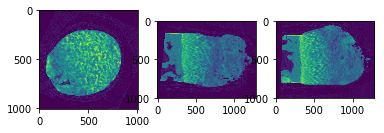

2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

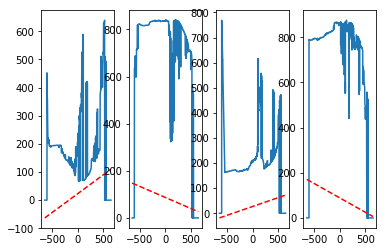

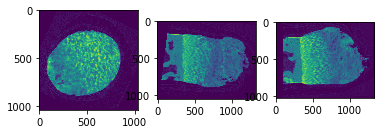

3. Crop and flip center volume:


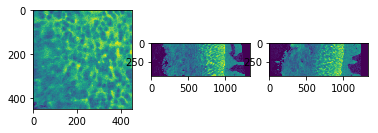

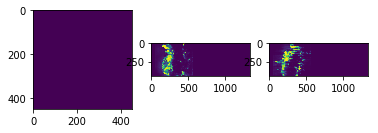

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:', max=448.0)

interface dims: {0},{1} 448 448


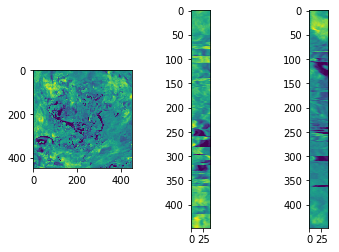

Data shape : 448,448,1330
Mask shape : 448,448,1330


FloatProgress(value=0.0, description='Get interface:', max=448.0)

interface dims: {0},{1} 448 448
[382, 40, 342, 1330]
[381, 40, 341, 1330]
[379, 40, 339, 1330]
[377, 40, 337, 1330]
[4294967286, 40, 4294967246, 1330]


ValueError: could not broadcast input array from shape (0) into shape (40)

In [21]:
# Parameters
impath = r"Z:\3DHistoData\rekisteroidyt"
modelpath = r"Z:\Tuomas\UNetNew.model"
savepath = r"Z:\Tuomas\SurfaceImages"
sample = '15_L6TL_2'
threshold = 80
size = [448, 40, 10] # width, depth

# List directories
files = os.listdir(impath)
files.sort()
for k in range(2, len(files), 4): # Skip 1 CA4+ file and 2 .zip files
    try:
        file = os.listdir(impath + "\\" + files[k] + "\\" + "Registration" )
        pth = impath + "\\" + files[k] + "\\" + "Registration"
    except FileNotFoundError: # Case: sample name folder twice
        try:
            file = os.listdir(impath + "\\" + files[k] + "\\" + files[k] + "\\" + "Registration" )
            pth = impath + "\\" + files[k] + "\\" + files[k] + "\\" + "Registration"
        except FileNotFoundError: # Case: Unusable folder
            continue
    # Leave maskpath empty, since mask is segmented from samples
    Pipeline(pth, files[k], savepath, threshold, size, "", modelpath)

### Individual sample pipeline

Sample name: 15_L6TL_2
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=371.0)

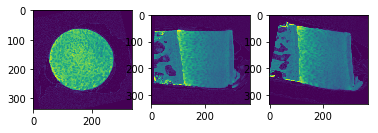

FloatProgress(value=0.0, description='Loading:', max=370.0)

(336, 336, 370)


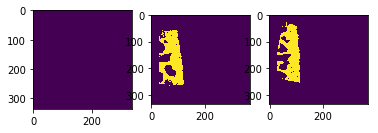

2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

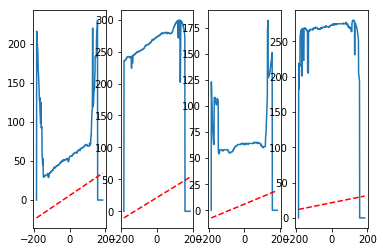

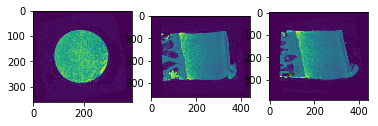

FloatProgress(value=0.0, description='Rotate mask:')

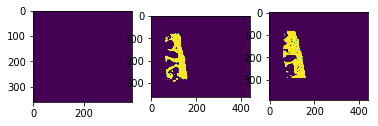

3. Crop and flip center volume:


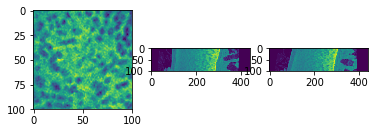

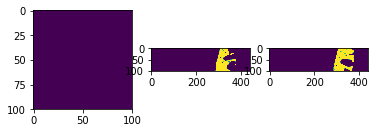

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:')

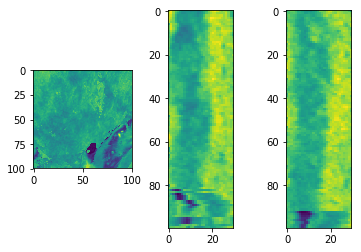

FloatProgress(value=0.0, description='Get interface:')

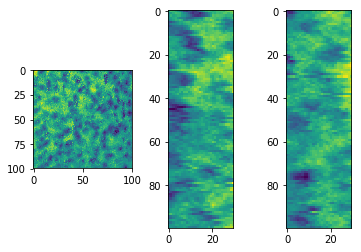

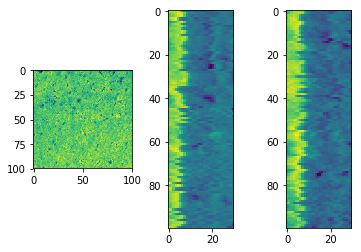

5. Save mean and std images


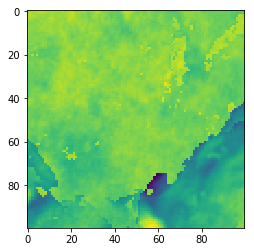

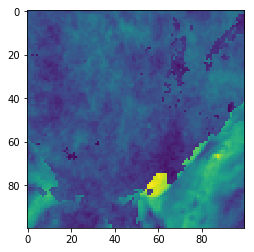

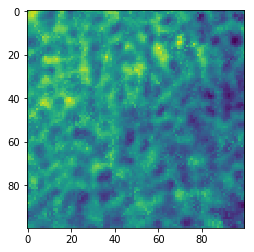

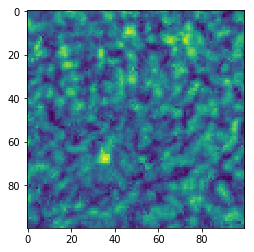

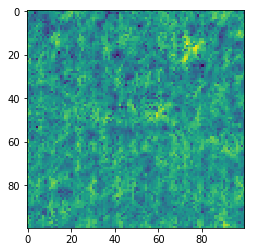

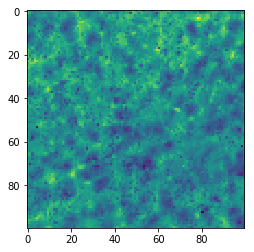

In [4]:
# Pipeline for binned sample and loaded mask
path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned"
mask = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned\bonemask"
savepath = r"Z:\3DHistoData\SurfaceImages"
modelpath = r"Z:\Tuomas\cntkunet.model"
sample = '15_L6TL_2'
threshold = 80
size = [100, 30, 3] # width, depth, bci offset

Pipeline(path, sample, savepath, threshold, size, mask)

### VTK rendering

FloatProgress(value=0.0, description='Loading:', max=1260.0)

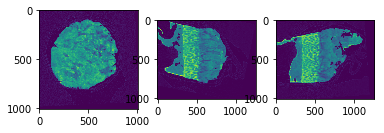

In [35]:
# Load and render

path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned"
path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Registration"
mask = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned\bonemask"
data, bounds = Load(path)
PrintOrthogonal(data)
RenderVolume(data)

### VTK processing

In [ ]:
def ArrayToVTK(A):
    imagedata = vtk.vtkImageData()
    depthArray = numpy_support.numpy_to_vtk(A.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
    imagedata.SetDimensions(A.shape)
    imagedata.SetOrigin(0,0,0)
    imagedata.GetPointData().SetScalars(depthArray)
    return imagedata

def VTKToArray(vtkdata, shape):
    array = numpy_support.vtk_to_numpy(vtkdata)
    array = array.reshape(shape)
    return array

def RotateVTK(vtkdata, angles):
    # Initialize
    mapper = vtk.vtkFixedPointVolumeRayCastMapper()
    mapper.SetInputData(vtkdata)
    actor = vtk.vtkActor()

    cx, cy, cz = actor.GetCenter()

    transf = vtk.vtkTransform()
    transf.Translate(cx, cy, cz)
    transf.RotateX(angles[0])
    transf.RotateY(angles[1])
    transf.RotateZ(angles[2])
    transf.Translate(-cx, -cy, -cz)
    
    slicer = vtk.vtkImageReslice()
    slicer.SetInputData(vtkdata)
    slicer.Set

    return vtkdata

In [ ]:
# Rotate VTK

array = data[:,:,:]
shape = np.shape(array)
vtkdata = ArrayToVTK(array)
Render(vtkdata)
vtkdata = RotateVTK(vtkdata, [90,0,0])
array2 = VTKToArray(vtkdata, shape)
PrintOrthogonal(array)
PrintOrthogonal(array2 - array)

In [ ]:
# Save to h5

savepath = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Saved"
h5 = h5py.File('filename.h5','w')
h5.create_dataset('mean',data=mean)
h5.create_dataset('std',data=std)
h5.close()

h5 = h5py.File('filename.h5','r')
mean = h5['mean'][:]
h5.close()

In [ ]:
# Segment slice

z = C.load_model('Z:\Tuomas\cntkunet.model')
print(data.shape)
sliced = data[100:868, 500, 0:768]
sliced = (sliced - 113.05652141)/39.87462853
print(sliced.shape)
plt.imshow(sliced); plt.show()
data = None
mask = z.eval(sliced.reshape(1,sliced.shape[0],sliced.shape[1]))
plt.imshow(mask[0].squeeze()); plt.show()